# Проект: классификация

In [330]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

Данные о клиентах банка:

- age (возраст);
- job (сфера занятости);
- marital (семейное положение);
- education (уровень образования);
- default (имеется ли просроченный кредит);
- housing (имеется ли кредит на жильё);
- loan (имеется ли кредит на личные нужды);
- balance (баланс).

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

- contact (тип контакта с клиентом);
- month (месяц, в котором был последний контакт);
- day (день, в который был последний контакт);
- duration (продолжительность контакта в секундах).

Прочие признаки:

- campaign (количество контактов с этим клиентом в течение текущей кампании);
- pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- previous (количество контактов до текущей кампании)
- poutcome (результат прошлой маркетинговой кампании).

И, разумеется, наша целевая переменная deposit, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

In [331]:
df = pd.read_csv('bank_fin.csv', sep = ';')
df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [332]:
#Расссмотрим столбцы поподробнее
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


**Некоторые первые выводы:**

* Есть пропуски в балансе (`balance`)
* В данных присуствуют категориальные признаки, которые надо будет закодировать. 

### Задание 2

In [333]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

### Задание 3

In [334]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].apply(lambda x: x.replace('$', '') if isinstance(x, str) else x)
df['balance'] = df['balance'].apply(lambda x: x.replace(' ', '') if isinstance(x, str) else x)
df['balance'] = df['balance'].apply(lambda x: x.replace(',00', '') if isinstance(x, str) else x)
df['balance'] = df['balance'].apply(lambda x: x.replace(',0', '') if isinstance(x, str) else x)

In [335]:
df['balance'] = df['balance'].astype(float)
df['balance'].mean()

1529.1290293615875

### Задание 4

In [336]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())
df['balance'].mean()


1526.9360329690019

### Задание 5

In [337]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
df['job'] = df['job'].apply(lambda x: df['job'].mode if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: df['education'].mode if x == 'unknown' else x)

In [338]:
edu = df['education'].value_counts().to_frame()
e = edu.index[0]
job = df['job'].value_counts().to_frame()
j = job.index[0]

df[df['education'] == e][df['job'] == j]['balance'].mean()

1353.6134453781513

### Задание 6

In [339]:
def outliers_iqr_mod(data, feature, left=1.5, right=1.5):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>=lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, lower_bound, upper_bound

outliers, cleaned, l, u = outliers_iqr_mod(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')

print(f'Верхняя граница: {u}, нижняя граница: {l}')

Число выбросов по методу Тьюки: 1057
Верхняя граница: 4063.0, нижняя граница: -2241.0


In [340]:
# удалите все выбросы для признака balance
df = cleaned
df.shape[0]

10105

## Часть 2:  Разведывательный анализ

### Задание 1

In [341]:
df['deposit'].value_counts()

deposit
no     5424
yes    4681
Name: count, dtype: int64

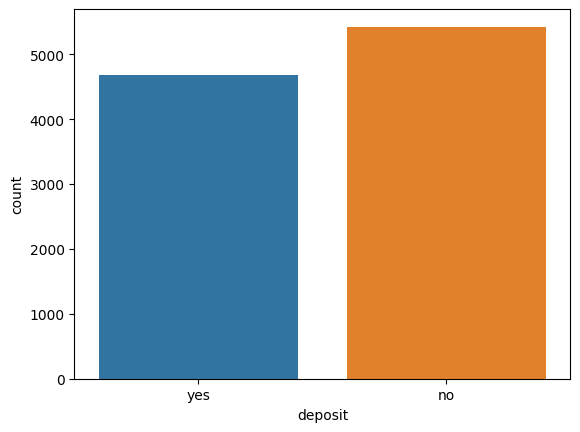

In [342]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
plt.figure()
sns.countplot(df, x='deposit')
plt.show()

Данные сбалансированы

### Задания 2 и 3

In [343]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


### Задания 4 и 5

In [344]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
df.describe(include='object')
#постройте визуализации, иллюстрирующие результаты

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,12,3,4,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2254,5715,5078,9939,5243,8712,7283,2617,7570,5424


### Задание 6

In [345]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
agg_func = {'deposit': ['value_counts']}
df.groupby(['poutcome']).agg(agg_func)

deposit
                 value_counts
poutcome deposit             
failure  no               562
         yes              547
other    yes              265
         no               216
success  yes              861
         no                84
unknown  no              4562
         yes             3008

### Задание 7

In [346]:
year = df['month'].unique()

for m in list(year):
    display(m)
    display(df[df['month'] == m]['deposit'].value_counts(normalize=True))

'may'

deposit
no     0.67864
yes    0.32136
Name: proportion, dtype: float64

'jun'

deposit
no     0.548913
yes    0.451087
Name: proportion, dtype: float64

'jul'

deposit
no     0.589563
yes    0.410437
Name: proportion, dtype: float64

'aug'

deposit
no     0.559567
yes    0.440433
Name: proportion, dtype: float64

'oct'

deposit
yes    0.814925
no     0.185075
Name: proportion, dtype: float64

'nov'

deposit
no     0.584615
yes    0.415385
Name: proportion, dtype: float64

'dec'

deposit
yes    0.903226
no     0.096774
Name: proportion, dtype: float64

'jan'

deposit
no     0.60815
yes    0.39185
Name: proportion, dtype: float64

'feb'

deposit
yes    0.544429
no     0.455571
Name: proportion, dtype: float64

'mar'

deposit
yes    0.898734
no     0.101266
Name: proportion, dtype: float64

'apr'

deposit
yes    0.618072
no     0.381928
Name: proportion, dtype: float64

'sep'

deposit
yes    0.834532
no     0.165468
Name: proportion, dtype: float64

In [347]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
agg_func = {'deposit': ['value_counts']}
df.groupby(['month']).agg(agg_func, normalize=True)

deposit
              value_counts
month deposit             
apr   yes              513
      no               317
aug   no               775
      yes              610
dec   yes               84
      no                 9
feb   yes              386
      no               323
jan   no               194
      yes              125
jul   no               836
      yes              582
jun   no               606
      yes              498
mar   yes              213
      no                24
may   no              1776
      yes              841
nov   no               456
      yes              324
oct   yes              273
      no                62
sep   yes              232
      no                46

### Задание 8

In [348]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
cut_labels = ['<30', '30-40', '40-50', '50-60', '60+']
cut_bins = [0, 30, 40, 50, 60, 99]

df['age_group'] = pd.cut(df['age'],
                       bins=cut_bins,
                       labels=cut_labels)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,50-60
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,50-60
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,40-50
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,50-60
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,50-60


In [349]:
df_encod = pd.get_dummies(df, columns=['deposit', ])
df_encod.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,age_group,deposit_no,deposit_yes
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,50-60,False,True
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,50-60,False,True
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,40-50,False,True
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,50-60,False,True
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,50-60,False,True


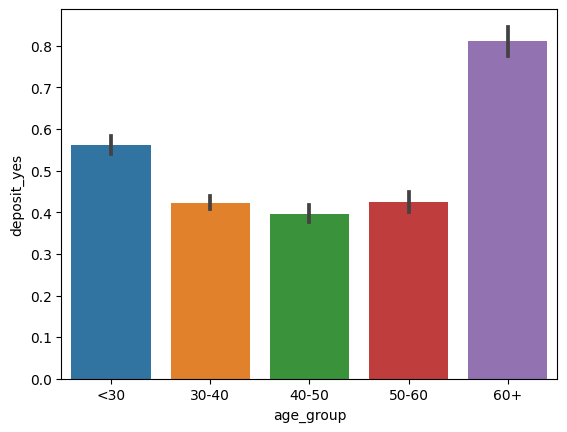

In [350]:
#pivot = pd.pivot(df, index='age_group', columns='deposit')
plt.figure()
sns.barplot(df_encod, y='deposit_yes', x='age_group')
plt.show()

### Задания 9 и 10

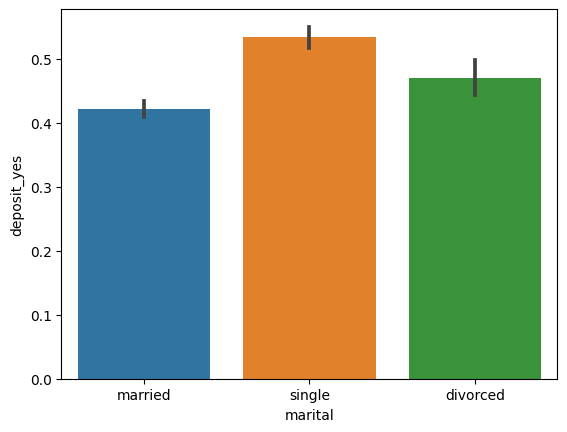

In [351]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
plt.figure()
sns.barplot(df_encod, y='deposit_yes', x='marital')
plt.show()

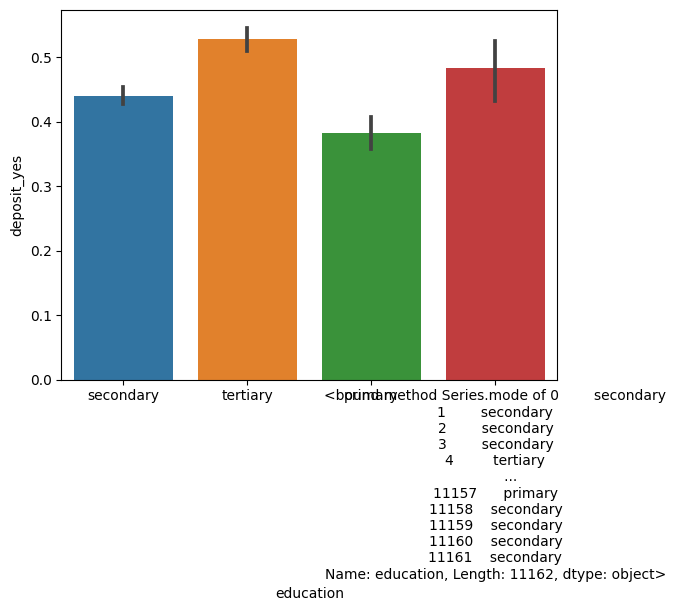

In [352]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
plt.figure()
sns.barplot(df_encod, y='deposit_yes', x='education')
plt.show()

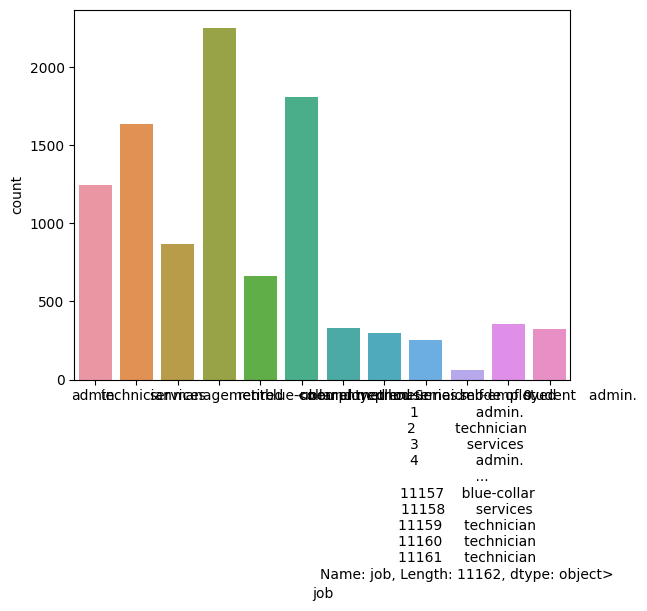

In [353]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
plt.figure()
sns.countplot(df_encod,  x='job')
plt.show()

In [354]:
df_encod['job'].value_counts(normalize=True)

job
management                                                                                                                                                                                                                                                                                                                 0.223058
blue-collar                                                                                                                                                                                                                                                                                                                0.178822
technician                                                                                                                                                                                                                                                                                                                 0.162098
admin.                  

### Задание 11

In [355]:
df_encod_yes = df_encod[df_encod['deposit_yes']==True]
df_encod_no = df_encod[df_encod['deposit_no']==True]
df_encod_no

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,age_group,deposit_no,deposit_yes
5289,57,retired,single,primary,no,604.0,no,no,cellular,19,nov,187,1,-1,0,unknown,50-60,True,False
5290,45,admin.,divorced,secondary,no,0.0,yes,no,cellular,17,nov,102,1,-1,0,unknown,40-50,True,False
5291,48,blue-collar,married,secondary,no,238.0,yes,yes,cellular,2,jun,118,2,81,1,success,40-50,True,False
5292,34,admin.,single,secondary,no,673.0,yes,no,cellular,29,jan,89,1,260,2,failure,30-40,True,False
5294,32,management,married,tertiary,no,3696.0,no,no,unknown,21,may,315,3,-1,0,unknown,30-40,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,30-40,True,False
11158,39,services,married,secondary,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,30-40,True,False
11159,32,technician,single,secondary,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,30-40,True,False
11160,43,technician,married,secondary,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,40-50,True,False


In [356]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
# (если рассматривать тех, кто открыл депозит)
pivot_yes = pd.pivot_table(df_encod_yes, index='education', columns='marital',aggfunc='count')
pivot_yes

age                 \
marital                                            divorced married single   
education                                                                    
<bound method Series.mode of 0        secondary...       18     120     74   
primary                                                  96     339     82   
secondary                                               265    1169    805   
tertiary                                                174     784    755   

                                                   age_group                 \
marital                                             divorced married single   
education                                                                     
<bound method Series.mode of 0        secondary...        18     120     74   
primary                                                   96     339     82   
secondary                                                265    1169    805   
tertiary                                                 174     784    755   

                                                    balance                 \
marital                                            divorced married single   
education                                                                    
<bound method Series.mode of 0        secondary...       18     120     74   
primary                                                  96     339     82   
secondary                                               265    1169    805   
tertiary                                                174     784    755   

                                                   campaign  ...  month  \
marital                                            divorced  ... single   
education                                                    ...          
<bound method Series.mode of 0        secondary...       18  ...     74   
primary                                                  96  ...     82   
secondary                                               265  ...    805   
tertiary                                                174  ...    755   

                                                      pdays                 \
marital                                            divorced married single   
education                                                                    
<bound method Series.mode of 0        secondary...       18     120     74   
primary                                                  96     339     82   
secondary                                               265    1169    805   
tertiary                                                174     784    755   

                                                   poutcome                 \
marital                                            divorced married single   
education                                                                    
<bound method Series.mode of 0        secondary...       18     120     74   
primary                                                  96     339     82   
secondary                                               265    1169    805   
tertiary                                                174     784    755   

                                                   previous                 
marital                                            divorced married single  
education                                                                   
<bound method Series.mode of 0        secondary...       18     120     74  
primary                                                  96     339     82  
secondary                                               265    1169    805  
tertiary                                                174     784    755  

[4 rows x 51 columns]

<AxesSubplot: xlabel='marital', ylabel='education'>

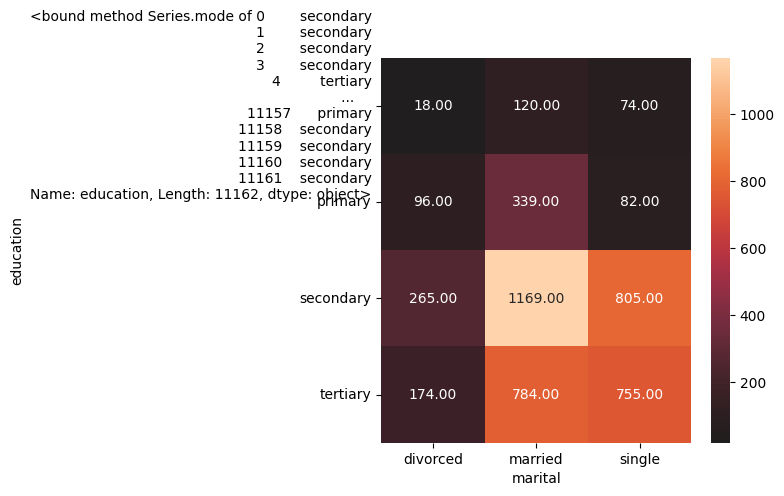

In [357]:
plt.figure(figsize=(5,5))  
sns.heatmap(pivot_yes['age'],fmt='.2f',annot=True, center=0)

In [358]:
pivot_no = pd.pivot_table(df_encod_no, index='education', columns='marital',aggfunc='count')
pivot_no

age                 \
marital                                            divorced married single   
education                                                                    
<bound method Series.mode of 0        secondary...       23     137     67   
primary                                                  91     641    100   
secondary                                               347    1693    799   
tertiary                                                163     832    531   

                                                   age_group                 \
marital                                             divorced married single   
education                                                                     
<bound method Series.mode of 0        secondary...        23     137     67   
primary                                                   91     641    100   
secondary                                                347    1693    799   
tertiary                                                 163     832    531   

                                                    balance                 \
marital                                            divorced married single   
education                                                                    
<bound method Series.mode of 0        secondary...       23     137     67   
primary                                                  91     641    100   
secondary                                               347    1693    799   
tertiary                                                163     832    531   

                                                   campaign  ...  month  \
marital                                            divorced  ... single   
education                                                    ...          
<bound method Series.mode of 0        secondary...       23  ...     67   
primary                                                  91  ...    100   
secondary                                               347  ...    799   
tertiary                                                163  ...    531   

                                                      pdays                 \
marital                                            divorced married single   
education                                                                    
<bound method Series.mode of 0        secondary...       23     137     67   
primary                                                  91     641    100   
secondary                                               347    1693    799   
tertiary                                                163     832    531   

                                                   poutcome                 \
marital                                            divorced married single   
education                                                                    
<bound method Series.mode of 0        secondary...       23     137     67   
primary                                                  91     641    100   
secondary                                               347    1693    799   
tertiary                                                163     832    531   

                                                   previous                 
marital                                            divorced married single  
education                                                                   
<bound method Series.mode of 0        secondary...       23     137     67  
primary                                                  91     641    100  
secondary                                               347    1693    799  
tertiary                                                163     832    531  

[4 rows x 51 columns]

<AxesSubplot: xlabel='marital', ylabel='education'>

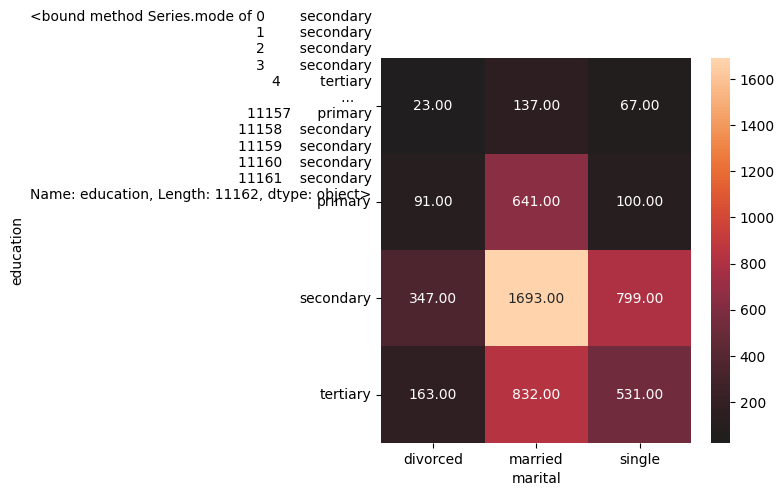

In [359]:
plt.figure(figsize=(5,5))  
sns.heatmap(pivot_no['age'],fmt='.2f',annot=True, center=0)

Можно сделать вывод, что наиболее популярные группы людей для открывших депозит и для неоткрывших - одинаковы. Это значит, что факт открытия депозита не зависит от семейного положения и уровня образования человека.

## Часть 3: преобразование данных

### Задание 1

In [360]:
# преобразуйте уровни образования

LE=LabelEncoder()

df['education'] = df['education'].astype(str)
df['education'] = LE.fit_transform(df['education'])
df['education'].sum()

21222

In [361]:
df['age_group'] = LE.fit_transform(df['age_group'])
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,2,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,2
1,56,admin.,married,2,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,2
2,41,technician,married,2,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,1
3,55,services,married,2,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,2
4,54,admin.,married,3,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,2


### Задания 2 и 3

In [362]:
# преобразуйте бинарные переменные в представление из нулей и единиц

df['deposit'] = df['deposit'].apply(lambda x: 1 if x=='yes' else 0)

display(df['deposit'].std())

0.4986712532452124

In [363]:
df['default'] = df['default'].apply(lambda x: 1 if x=='yes' else 0)
df['housing'] = df['housing'].apply(lambda x: 1 if x=='yes' else 0)
df['loan'] = df['loan'].apply(lambda x: 1 if x=='yes' else 0)

In [364]:
display(df['default'].mean() + df['housing'].mean() + df['loan'].mean())

0.6354280059376547

### Задание 4

In [365]:
# создайте дамми-переменные
df_dum = pd.get_dummies(df, columns=['job', 'marital', 'contact', 'month', 'poutcome'],)
df_dum

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,2,0,2343.0,1,0,5,1042,1,-1,...,False,False,True,False,False,False,False,False,False,True
1,56,2,0,45.0,0,0,5,1467,1,-1,...,False,False,True,False,False,False,False,False,False,True
2,41,2,0,1270.0,1,0,5,1389,1,-1,...,False,False,True,False,False,False,False,False,False,True
3,55,2,0,2476.0,1,0,5,579,1,-1,...,False,False,True,False,False,False,False,False,False,True
4,54,3,0,184.0,0,0,5,673,2,-1,...,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,1,0,1.0,1,0,20,257,1,-1,...,False,False,False,False,False,False,False,False,False,True
11158,39,2,0,733.0,0,0,16,83,4,-1,...,True,False,False,False,False,False,False,False,False,True
11159,32,2,0,29.0,0,0,19,156,2,-1,...,False,False,False,False,False,False,False,False,False,True
11160,43,2,0,0.0,0,1,8,9,2,172,...,False,False,True,False,False,False,True,False,False,False


In [366]:
for c in df_dum.columns:
    df_dum[c] = df_dum[c].replace({ True : 1 , False : 0 })

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,2,0,2343.0,1,0,5,1042,1,-1,...,0,0,1,0,0,0,0,0,0,1
1,56,2,0,45.0,0,0,5,1467,1,-1,...,0,0,1,0,0,0,0,0,0,1
2,41,2,0,1270.0,1,0,5,1389,1,-1,...,0,0,1,0,0,0,0,0,0,1
3,55,2,0,2476.0,1,0,5,579,1,-1,...,0,0,1,0,0,0,0,0,0,1
4,54,3,0,184.0,0,0,5,673,2,-1,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,1,0,1.0,1,0,20,257,1,-1,...,0,0,0,0,0,0,0,0,0,1
11158,39,2,0,733.0,0,0,16,83,4,-1,...,1,0,0,0,0,0,0,0,0,1
11159,32,2,0,29.0,0,0,19,156,2,-1,...,0,0,0,0,0,0,0,0,0,1
11160,43,2,0,0.0,0,1,8,9,2,172,...,0,0,1,0,0,0,1,0,0,0


In [388]:
df_dum.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10105 entries, 0 to 11161
Data columns (total 47 columns):
 #   Column                                                                                                                                                                                                                                                                                                            Non-Null Count  Dtype  
---  ------                                                                                                                                                                                                                                                                                                            --------------  -----  
 0   age                                                                                                                                                                                                                          

### Задания 5 и 6

<AxesSubplot: >

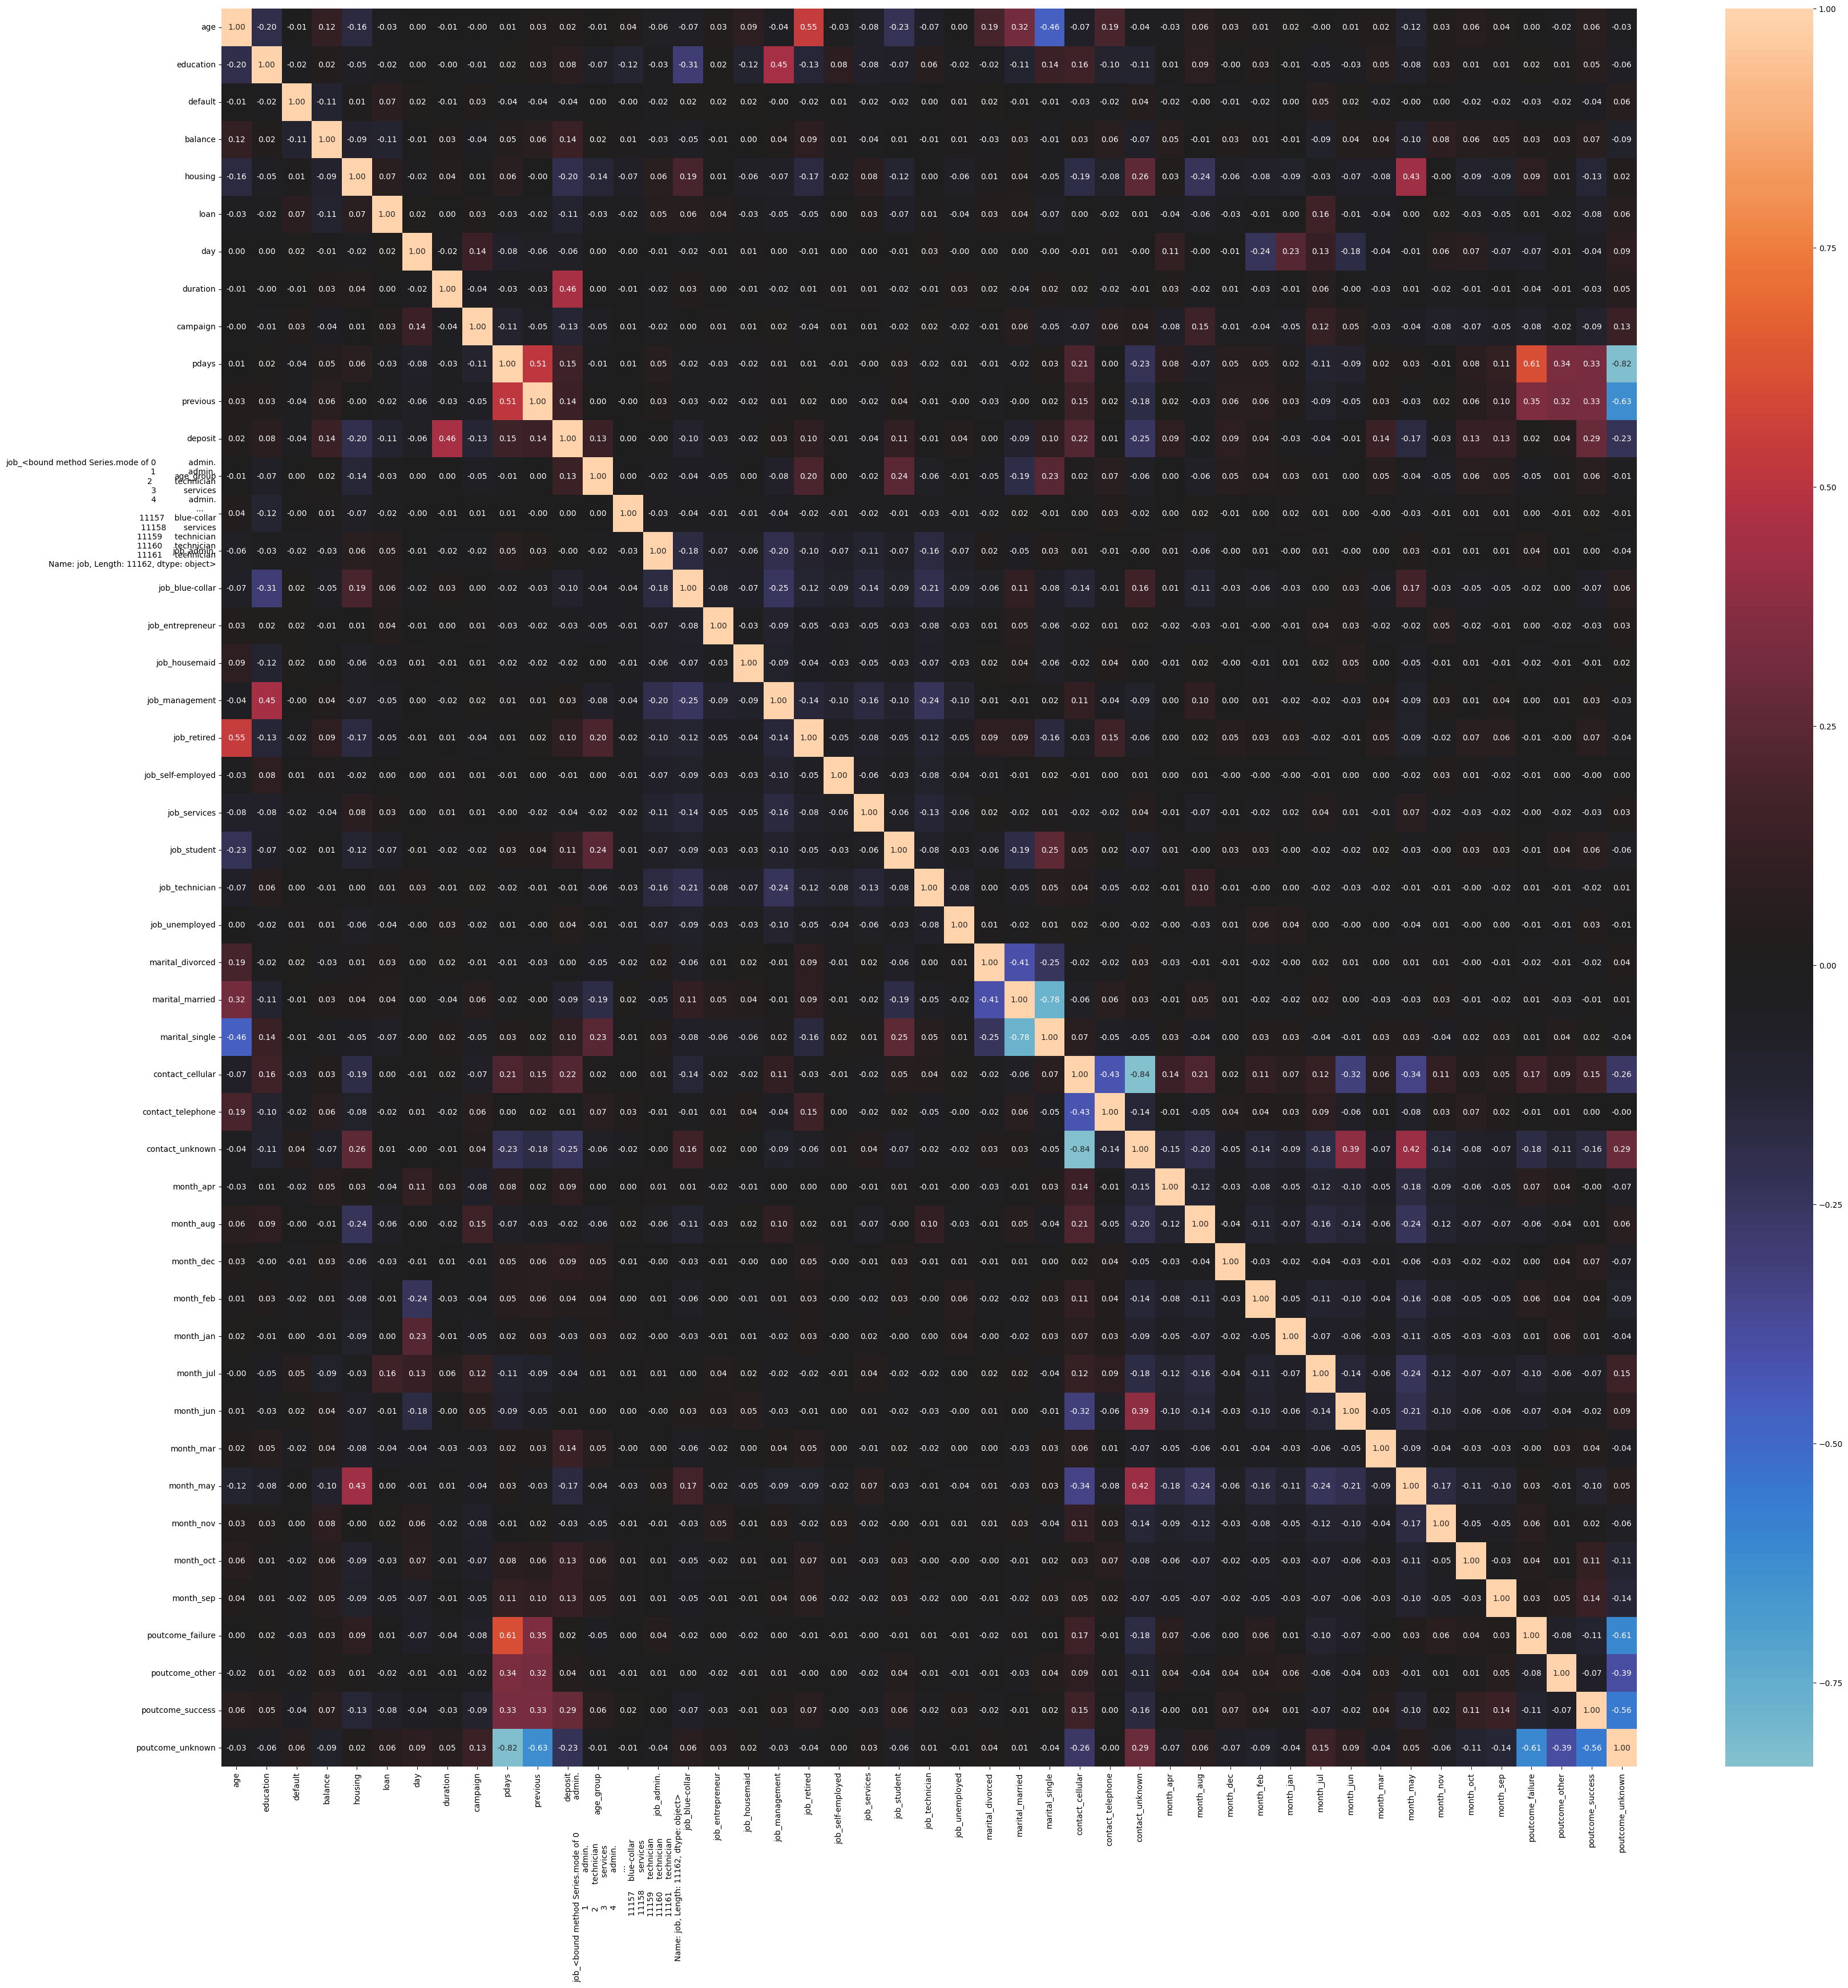

In [367]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

plt.figure(figsize=(40,40))  
sns.heatmap(df_dum.corr(),fmt='.2f',annot=True, center=0)

### Задания 7 и 8

In [368]:
X = df_dum.drop(['deposit'], axis=1)
y = df_dum['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)
X_test.shape

(3335, 46)

In [369]:
# рассчитайте необходимые показатели
y_test.mean()

0.46326836581709147

### Задание 9

In [370]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(k=15, score_func = f_classif).fit(X, y)
selector.get_support(indices=True)
X_15best = selector.transform(X)

In [371]:
vector_names = list(X.columns[selector.get_support(indices=True)])
print(vector_names)

['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous', 'age_group', 'contact_cellular', 'contact_unknown', 'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown']


### Задание 10

In [372]:
# нормализуйте данные с помощью minmaxsxaler
mm_scaler = preprocessing.MinMaxScaler()
X_scaled = mm_scaler.fit_transform(X_15best)

In [373]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state = 42, test_size = 0.33)

In [374]:
display(X_test[:,0].mean())

0.46823674223097866

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [375]:
# обучите логистическую регрессию и рассчитайте метрики качества
#Создаем объект класса логистическая регрессия
log_reg_full = linear_model.LogisticRegression(random_state=42, max_iter=1000, solver='sag')
#Обучаем модель, минизируя logloss
log_reg_full.fit(X_train, y_train)
#Делаем предсказание класса
y_pred = log_reg_full.predict(X_test)

#Рассчитываем accuracy
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_pred)))

Accuracy: 0.81


### Задания 2,3,4

In [391]:
# обучите решающие деревья, настройте максимальную глубину
des_tree = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)
des_tree.fit(X_train, y_train)
y_pred = des_tree.predict(X_test)

#Рассчитываем accuracy
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_pred)))

Accuracy: 0.75


In [394]:
# обучите решающие деревья, настройте максимальную глубину
des_tree = tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=9)
des_tree.fit(X_train, y_train)
y_train_pred = des_tree.predict(X_train)
y_test_pred = des_tree.predict(X_test)

#Рассчитываем accuracy
print('Accuracy train: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Accuracy test: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Accuracy train: 0.85
Accuracy test: 0.81


### Задание 5

In [395]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth':[3,5,7]
              }
grid_search = GridSearchCV(
        estimator=tree.DecisionTreeClassifier(
        random_state=42, #генератор случайных чисел
        criterion='entropy'
    ), 
    param_grid=param_grid 
)  
%time 
grid_search.fit(X_train, y_train) 
y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 0 ns
Wall time: 0 ns
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 10}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [386]:
# обучите на ваших данных случайный лес
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    criterion='gini',
    min_samples_leaf=5,
    random_state=42
)
#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)

y_test_pred = rf.predict(X_test)
print('Test: {}'.format(metrics.classification_report(y_test, y_test_pred)))

Test:               precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [396]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier

# Создаем объект класса градиентный бустинг
gb = GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42
)

# Обучаем модель
gb.fit(X_train, y_train)

# Формируем предсказание для тестовой выборки
gb_pred  = gb.predict(X_test)

# Оцениваем качество 
print('Test: {}'.format(metrics.classification_report(y_test, gb_pred)))

Test:               precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 4

In [398]:
# объедините уже известные вам алгоритмы с помощью стекинга 
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import RidgeCV, LinearRegression

# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('dt', tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=7, min_samples_split=10)),
    ('lr', linear_model.LogisticRegression(random_state=42, max_iter=1000, solver='sag')),
    ('gb', GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42
))]

# Создаем объект класса стекинг
reg = StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)

# Обучаем модель
reg.fit(X_train, y_train)

StackingClassifier(estimators=[('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=7,
                                                       min_samples_split=10,
                                                       random_state=42)),
                               ('lr',
                                LogisticRegression(max_iter=1000,
                                                   random_state=42,
                                                   solver='sag')),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=5,
                                                           min_samples_leaf=5,
                                                           n_estimators=300,
                                                           random_state=42))],
                   final_estimator=LogisticRegression(random_state=42))

In [399]:
# Формируем предсказание для тестовой выборки
y_pred_stack = reg.predict(X_test)
# Оцениваем качество по метрике presision
print(f'Качество предсказания стекинга {round(metrics.precision_score(y_test, y_pred_stack), 2)}')

Качество предсказания стекинга 0.81


### Задание 5

In [49]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [414]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.accuracy_score(y_test, model.predict(X_test))

  return score

In [415]:
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2024-01-25 16:07:46,331] A new study created in memory with name: RandomForestClassifier
[I 2024-01-25 16:07:48,324] Trial 0 finished with value: 0.8227886056971514 and parameters: {'n_estimators': 152, 'max_depth': 24, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8227886056971514.
[I 2024-01-25 16:07:50,349] Trial 1 finished with value: 0.8260869565217391 and parameters: {'n_estimators': 101, 'max_depth': 27, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8260869565217391.
[I 2024-01-25 16:07:53,090] Trial 2 finished with value: 0.8314842578710645 and parameters: {'n_estimators': 167, 'max_depth': 15, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.8314842578710645.
[I 2024-01-25 16:07:56,481] Trial 3 finished with value: 0.8314842578710645 and parameters: {'n_estimators': 116, 'max_depth': 15, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.8314842578710645.
[I 2024-01-25 16:07:59,479] Trial 4 finished with value: 0.8281859070464768 and parameters: {'n

In [416]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("метрики на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 167, 'max_depth': 15, 'min_samples_leaf': 4}
метрики на обучающем наборе: 0.83
